Load and pre-process data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
import torch 
import time
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader

# load 
X_Guys = np.load('/content/drive/MyDrive/dhl_exam/data/subcortical/X_Guys.npy')
y_Guys = np.load('/content/drive/MyDrive/dhl_exam/data/subcortical/y_Guys.npy')
ids_Guys = np.load('/content/drive/MyDrive/dhl_exam/data/subcortical/ids_Guys.npy')
X_HH = np.load('/content/drive/MyDrive/dhl_exam/data/subcortical/X_HH.npy')
y_HH = np.load('/content/drive/MyDrive/dhl_exam/data/subcortical/y_HH.npy')
ids_HH = np.load('/content/drive/MyDrive/dhl_exam/data/subcortical/ids_HH.npy')
X_IOP = np.load('/content/drive/MyDrive/dhl_exam/data/subcortical/X_IOP.npy')
y_IOP = np.load('/content/drive/MyDrive/dhl_exam/data/subcortical/y_IOP.npy')
ids_IOP = np.load('/content/drive/MyDrive/dhl_exam/data/subcortical/ids_IOP.npy')

#center data
def centring(X):
    X=np.asarray(X)
    epsilon = 1e-7 
    mean = np.mean(X, axis=0, keepdims=True)
    std = np.std(X, axis=0, keepdims=True)
    centered_array = (X - mean) / (std+epsilon)
    return centered_array


def to_one_hot_5_matrix_batch(batch_matrix):
    
    batch_matrix = np.array(batch_matrix, dtype='int')
    one_hot = np.zeros((batch_matrix.shape[0], 5, batch_matrix.shape[1], batch_matrix.shape[2]), dtype=float)
    one_hot[:, 0] = batch_matrix == 0
    one_hot[:, 1] = batch_matrix == 1
    one_hot[:, 2] = batch_matrix == 2
    one_hot[:, 3] = batch_matrix == 3
    one_hot[:, 4] = batch_matrix == 4
    return one_hot


X_Guys_centered=centring(X_Guys)
X_HH_centered=centring(X_HH)
X_IOP_centered=centring(X_IOP)
# producing required train / val / test split
print("initial shapes")
print(X_Guys.shape)
print(y_Guys.shape)
print(ids_Guys.shape)
print(X_HH.shape)
print(y_HH.shape)
print(ids_HH.shape)
print(X_IOP.shape)
print(y_IOP.shape)
print(ids_IOP.shape)

combined_Guys_HH_X = np.concatenate([X_Guys_centered, X_HH_centered], axis=0)
combined_Guys_HH_y = np.concatenate([y_Guys, y_HH], axis=0)

X_train = torch.Tensor(combined_Guys_HH_X[0:int(len(combined_Guys_HH_X)*0.85)])
y_train = torch.Tensor(combined_Guys_HH_y[0:int(len(combined_Guys_HH_y)*0.85)])

# val data 15%
X_val = torch.Tensor(combined_Guys_HH_X[int(len(combined_Guys_HH_X)*0.85):int(len(combined_Guys_HH_X))])
y_val = torch.Tensor(combined_Guys_HH_y[int(len(combined_Guys_HH_y)*0.85):int(len(combined_Guys_HH_y))])
#test data from IOP data
X_test =  torch.Tensor(X_IOP_centered[0:int(len(X_IOP_centered))])
y_test = torch.Tensor(y_IOP[0:int(len(y_IOP))])

print("Check after split")
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

# slice data into 2D
def reslice(x, split_size):
  temp = torch.split(x,split_size,dim=1)
  output=[]
  for i in range(len(temp)):
    output.append(temp[i])
  output=torch.cat(output, dim=0)
  return output



X_train=X_train[:,10,:,:]
X_val=X_val[:,10,:,:]
X_test=X_test[:,10,:,:]
y_train=y_train[:,10,:,:]
y_val=y_val[:,10,:,:]
y_test=y_test[:,10,:,:]

#X_train2=X_train[:,20,:,:]
#X_val2=X_val[:,20,:,:]
#X_test2=X_test[:,20,:,:]
#y_train2=y_train[:,20,:,:]
#y_val2=y_val[:,20,:,:]
#y_test2=y_test[:,20,:,:]

#X_train3=X_train[:,30,:,:]
#X_val3=X_val[:,30,:,:]
#X_test3=X_test[:,30,:,:]
#y_train3=y_train[:,30,:,:]
#y_val3=y_val[:,30,:,:]
#y_test3=y_test[:,30,:,:]

#X_train4=X_train[:,0,:,:]
#X_val4=X_val[:,0,:,:]
#X_test4=X_test[:,0,:,:]
#y_train4=y_train[:,0,:,:]
#y_val4=y_val[:,0,:,:]
#y_test4=y_test[:,0,:,:]

#X_train=torch.cat((X_train1, X_train2, X_train3, X_train4), dim=0)
#X_val=torch.cat((X_val1, X_val2, X_val3, X_val4), dim=0)
#X_test=torch.cat((X_test1, X_test2, X_test3, X_test4), dim=0)

#y_train=torch.cat((y_train1, y_train2, y_train3, y_train4), dim=0)
#y_val=torch.cat((y_train1, y_train2, y_train3, y_train4), dim=0)
#y_test=torch.cat((y_train1, y_train2, y_train3, y_train4), dim=0)

#introduce channel
X_train=torch.reshape(X_train,(len(X_train),1,128,128))
X_val=torch.reshape(X_val,(len(X_val),1,128,128))
X_test=torch.reshape(X_test,(len(X_test),1,128,128))
y_train = torch.reshape(y_train,(len(y_train),128,128))
y_val= torch.reshape(y_val,(len(y_val),128,128))
y_test = torch.reshape(y_test,(len(y_test),128,128))
y_train = to_one_hot_5_matrix_batch(y_train)
y_val= to_one_hot_5_matrix_batch(y_val)
y_test =to_one_hot_5_matrix_batch((y_test))


print("Check shapes after slicing into 2D")
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)


X_train=np.asarray(X_train)
X_val=np.asarray(X_val)
X_test=np.asarray(X_test)
y_train=np.asarray(y_train)
y_val=np.asarray(y_val)
y_test=np.asarray(y_test)


class numpy_dataset(Dataset): 
    def __init__(self, data, target): 
        self.data =  torch.from_numpy(data)
        self.target = torch.from_numpy(target)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y

    def __len__(self):
        return len(self.data)
train_dataset = numpy_dataset(X_train, y_train)
val_dataset = numpy_dataset(X_val, y_val)
test_dataset = numpy_dataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, drop_last=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
initial shapes
(321, 40, 128, 128)
(321, 40, 128, 128)
(321,)
(185, 40, 128, 128)
(185, 40, 128, 128)
(185,)
(71, 40, 128, 128)
(71, 40, 128, 128)
(71,)
Check after split
torch.Size([430, 40, 128, 128])
torch.Size([430, 40, 128, 128])
torch.Size([76, 40, 128, 128])
torch.Size([76, 40, 128, 128])
torch.Size([71, 40, 128, 128])
torch.Size([71, 40, 128, 128])
Check shapes after slicing into 2D
torch.Size([430, 1, 128, 128])
(430, 5, 128, 128)
torch.Size([76, 1, 128, 128])
(76, 5, 128, 128)
torch.Size([71, 1, 128, 128])
(71, 5, 128, 128)


Checking data

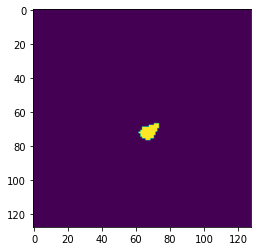

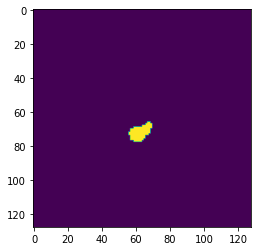

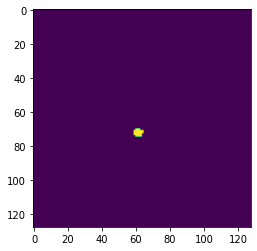

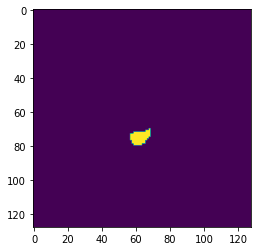

In [ ]:
train_dataset = numpy_dataset(X_train, y_train)
val_dataset = numpy_dataset(X_val, y_val)
test_dataset = numpy_dataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)


for data, labels in test_dataloader:
  plt.imshow(labels[0][3])
  plt.show()



Training functions

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#  training loop + dice function adapted from Kaggle

def dice_coef_metric(pred, label, num_classes=5, eps=1e-7):
    pred = F.one_hot(torch.argmax(pred, dim=1), num_classes=num_classes).permute(0, 3, 1, 2).float()

    
    intersection = (pred * label).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + label.sum(dim=(2, 3))

    dice = (2 * intersection + eps) / (union + eps)
    return dice.mean().item()

def dice_coef_loss(pred, label, num_classes=5, eps=1e-7):
    intersection = (pred * label).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + label.sum(dim=(2, 3))

    dice = (2 * intersection + eps) / (union + eps)
    return 1 - dice.mean()

def bce_dice_loss(pred, label, num_classes=5):
    dice_loss = dice_coef_loss(pred, label, num_classes=num_classes)
    label_argmax = label.argmax(dim=1)
    bce_loss = nn.CrossEntropyLoss()(pred, label_argmax)
    return dice_loss + bce_loss


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss


def train_loop(model, loader, loss_func,optimizer):
    model.train()
    train_losses = []
    train_dices = []
    
    for i, (image, mask) in enumerate(loader):
        image = image.to(device).float()
        mask = mask.to(device).float()
        outputs = model(image)
        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0            

        dice = dice_coef_metric(torch.tensor(out_cut).to(device), mask.data.to(device))
        loss = loss_func(outputs, mask)
        train_losses.append(loss.item())
        train_dices.append(dice)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    return train_dices, train_losses

def eval_loop(model, loader, loss_func, scheduler,training=True):
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for step, (image, mask) in enumerate(loader):
            image = image.to(device).float()
            mask = mask.to(device).float()
    
            outputs = model(image)
            loss = loss_func(outputs, mask)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            dice = dice_coef_metric(torch.tensor(out_cut).to(device), mask.data.to(device))
            
            val_loss += loss
            val_dice += dice
        
        val_mean_dice = val_dice / len(loader)
        val_mean_loss = val_loss / step
        
        if training:
            scheduler.step(val_mean_dice)
        
    return val_mean_dice, val_mean_loss

def train_model(train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs):
    train_loss_history = []
    train_dice_history = []
    val_loss_history = []
    val_dice_history = []
    
    for epoch in range(num_epochs):
        train_dices, train_losses = train_loop(model, train_loader, loss_func,optimizer)
        train_mean_dice = np.array(train_dices).mean()
        train_mean_loss = np.array(train_losses).mean()
        val_mean_dice, val_mean_loss = eval_loop(model, val_loader, loss_func,scheduler)
        
        train_loss_history.append(np.array(train_losses).mean())
        train_dice_history.append(np.array(train_dices).mean())
        val_loss_history.append(val_mean_loss.cpu().numpy())
        val_dice_history.append(val_mean_dice)
        
        print('Epoch: {}/{} |  Train Loss: {:.3f}, Val Loss: {:.3f}, Train DICE: {:.3f}, Val DICE: {:.3f}'.format(epoch+1, num_epochs,
                                                                                                                 train_mean_loss,
                                                                                                                 val_mean_loss,
                                                                                                                 train_mean_dice,
                                                                                                                 val_mean_dice))
        

    return train_loss_history, train_dice_history, val_loss_history, val_dice_history

def plot_dice_history(model_name, train_dice_history, val_dice_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_dice_history, label='Training DICE Score', lw=3)
    plt.plot(x, val_dice_history, label='Validation DICE Score', lw=3)

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE score", fontsize=15)

    path='/content/drive/MyDrive/dhl_exam/figures/'+str(model_name)+"-dice.png"
    plt.savefig(path)
    plt.show()
    

def plot_loss_history(model_name, train_loss_history, val_loss_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_loss_history, label='Training Loss', lw=3)
    plt.plot(x, val_loss_history, label='Validation Loss', lw=3)

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    path='/content/drive/MyDrive/dhl_exam/figures/'+str(model_name)+"-loss.png"
    plt.savefig(path)
    plt.show()
    

def prediction_dice(net, test_dataloader):
    test_dice = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_dataloader):
            data = data.to(device).float()
            target = target.to(device).float()

            pred = net(data)
            out_cut = np.copy(pred.data.cpu().numpy())
            out_cut[out_cut < 0.5] = 0.0
            out_cut[out_cut >= 0.5] = 1.0
            out_cut = torch.tensor(out_cut).to(device)
            dice = dice_coef_metric(out_cut, target)

            test_dice += dice
        mean_dice = test_dice / len(test_dataloader)
        return mean_dice


def predict(net, test_dataloader):
    test_dice=0

    with torch.no_grad():  
        for batch_idx, (data, target) in enumerate(test_dataloader):
          data = data.to(device).float()
          target = target.to(device).float()
           
          pred = net(data)
    return data.data.cpu().numpy(),target.data.cpu().numpy(),pred.data.cpu().numpy()

def train_model_early_stopping(train_loader, val_loader, loss_func,optimizer, scheduler, num_epochs, patience=5):
    train_loss_history = []
    train_dice_history = []
    val_loss_history = []
    val_dice_history = []

    best_val_dice = 0
    consecutive_no_improvement = 0
    
    for epoch in range(num_epochs):
        train_dices, train_losses = train_loop(model, train_loader, loss_func, optimizer)
        train_mean_dice = np.array(train_dices).mean()
        train_mean_loss = np.array(train_losses).mean()
        val_mean_dice, val_mean_loss = eval_loop(model, val_loader, loss_func,scheduler)
        
        train_loss_history.append(train_mean_loss)
        train_dice_history.append(train_mean_dice)
        val_loss_history.append(val_mean_loss.cpu().numpy())
        val_dice_history.append(val_mean_dice)
        
        print('Epoch: {}/{} |  Train Loss: {:.3f}, Val Loss: {:.3f}, Train DICE: {:.3f}, Val DICE: {:.3f}'.format(epoch+1, num_epochs,
                                                                                                                 train_mean_loss,
                                                                                                                 val_mean_loss,
                                                                                                                 train_mean_dice,
                                                                                                                 val_mean_dice))
      
        if val_mean_dice > best_val_dice:
            best_val_dice = val_mean_dice
            consecutive_no_improvement = 0
            print('Best validation dice coefficient improved to {:.3f}'.format(best_val_dice))
        else:
            consecutive_no_improvement += 1
            print('No improvement in validation dice coefficient for {} consecutive epochs'.format(consecutive_no_improvement))
            if consecutive_no_improvement >= patience:
                print('Early stopping triggered after {} epochs'.format(epoch+1))
                break

    return train_loss_history, train_dice_history, val_loss_history, val_dice_history,epoch+1


Models

In [ ]:

class SegNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SegNet, self).__init__()

        self.in_channels = in_channels
        self.num_classes = num_classes


        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.conv7 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        self.conv9 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn9 = nn.BatchNorm2d(64)
        self.conv10 = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x, pool1_indices = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x, pool2_indices = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x, pool3_indices = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x, pool4_indices = self.pool(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x, pool5_indices = self.pool(x)
        x = self.unpool(x, pool5_indices)
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.unpool(x, pool4_indices)
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.unpool(x, pool3_indices)
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.unpool(x, pool2_indices)
        x = F.relu(self.bn9(self.conv9(x)))
        x = self.conv10(x)
        x = F.interpolate(x, size=(128, 128), mode='bilinear', align_corners=False)
        return torch.sigmoid(x)


class FCN_flexible(nn.Module):
    def __init__(self, input_shape=(1, 128, 128), num_classes=2, dropout_prob=0.5, num_layers=5):
        super(FCN_flexible, self).__init__()
        encoder_layers = []
        in_channels = input_shape[0]
        for i in range(num_layers):
            out_channels = 64 * (2 ** i)
            encoder_layers.extend([
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_prob),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ])
            in_channels = out_channels

        self.encoder = nn.Sequential(*encoder_layers)
        self.middle = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob),
            nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        )
        decoder_layers = []
        for i in range(num_layers - 1, -1, -1):
            out_channels = 64 * (2 ** i)
            decoder_layers.extend([
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_prob)
            ])
            in_channels = out_channels

        decoder_layers.extend([
            nn.Conv2d(out_channels, num_classes, kernel_size=1),
            nn.Sigmoid()
        ])

        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x


def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = conv_block(in_channels, out_channels)

    def forward(self, x):
        return self.conv(self.pool(x))

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = conv_block(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat((skip, x), dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.init_conv = conv_block(in_channels, 64)
        self.encoders = nn.ModuleList([
            Encoder(64, 128),
            Encoder(128, 256),
            Encoder(256, 512),
            Encoder(512, 1024)
        ])
        self.decoders = nn.ModuleList([
            Decoder(1024, 512),
            Decoder(512, 256),
            Decoder(256, 128),
            Decoder(128, 64)
        ])
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.init_conv(x)
        skips = [x1]
        for encoder in self.encoders:
            skips.append(encoder(skips[-1]))

        x = skips.pop()
        for decoder in self.decoders:
            x = decoder(x, skips.pop())

        return self.final_conv(x)


In [ ]:
class MultiClassDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(MultiClassDiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
      

        assert inputs.size() == targets.size(), "Input and target dimensions should be the same"

        inputs = F.softmax(inputs, dim=1)

        num_classes = inputs.size(1)
        dice_per_class = 0
        
        for i in range(num_classes):
            input_i = inputs[:, i]
            target_i = targets[:, i]

            intersection = (input_i * target_i).sum()
            dice = (2. * intersection + smooth) / (input_i.sum() + target_i.sum() + smooth)
            dice_per_class += dice

        return 1 - dice_per_class / num_classes


num_epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet2D(1,5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
start_time = time.time()
train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model(train_dataloader, val_dataloader, bce_dice_loss, optimizer, scheduler, num_epochs)
end_time = time.time()

In [ ]:
prediction_dice(model,test_dataloader)

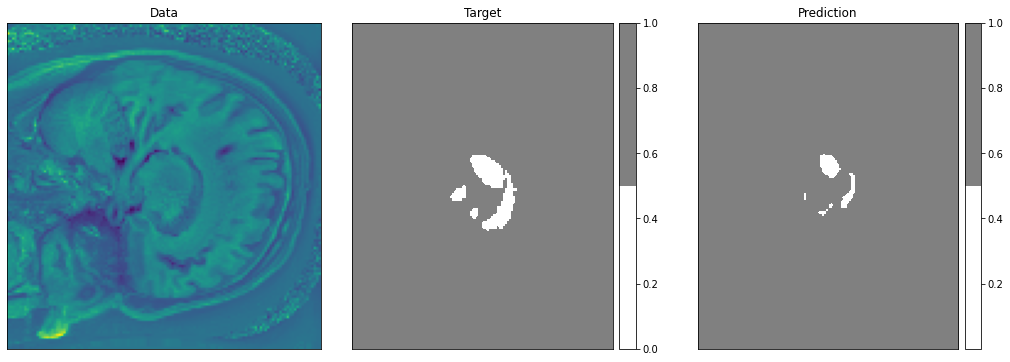

In [ ]:
from matplotlib.colors import ListedColormap
input, label,pred =predict(model,test_dataloader)
idx=5


custom_cmap = ListedColormap(['white', 'grey'])


fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)


im1 = axes[0].imshow(input[idx][0], aspect='auto')
axes[0].set_title('Data')

im2 = axes[1].imshow(label[idx][0], cmap=custom_cmap, aspect='auto')
axes[1].set_title('Target')
fig.colorbar(im2, ax=axes[1], pad=0.02)


im3 = axes[2].imshow(pred[idx][0
                               ], cmap=custom_cmap, aspect='auto')
axes[2].set_title('Prediction')
fig.colorbar(im3, ax=axes[2], pad=0.02)

plt.subplots_adjust(wspace=0.1)


plt.show()

In [ ]:
# save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/dhl_exam/models/unet_model_subcortical_best.pth')

In [ ]:
import torch

def sum_pixels_per_class(one_hot_tensor):
    one_hot_tensor = torch.from_numpy(one_hot_tensor)

    # Ensure the input tensor has the correct shape
    assert one_hot_tensor.shape == (5, 128, 128), "The input tensor shape should be (4, 128, 128)"
    
    # Sum the pixels for each class along the height and width dimensions
    pixel_sums = torch.sum(one_hot_tensor, dim=(1, 2))
    
    print(f"Sum of pixels for Class 0: {pixel_sums[0]}")
    print(f"Sum of pixels for Class 1: {pixel_sums[1]}")
    print(f"Sum of pixels for Class 2: {pixel_sums[2]}")
    print(f"Sum of pixels for Class 3: {pixel_sums[3]}")
    print(f"Sum of pixels for Class 3: {pixel_sums[4]}")
    return pixel_sums

def sum_pixels_per_class_batch(one_hot_batch_tensor):
    assert one_hot_batch_tensor.shape == (40, 5, 128, 128), "The input tensor shape should be (40, 4, 128, 128)"

    pixel_sums = torch.sum(one_hot_batch_tensor, dim=(0, 2, 3))
    
    return pixel_sums


In [ ]:
# data loader to load all testing data in sequence 
X_test = torch.tensor(np.concatenate([X_Guys_centered, X_HH_centered], axis=0))
y_test = torch.tensor(np.concatenate([y_Guys, y_HH], axis=0))

X_test_slices = np.asarray(reslice(X_test,1))
y_test_slices = reslice(y_test,1).reshape((-1, 128, 128))
y_test_slices = to_one_hot_5_matrix_batch(y_test_slices)
print(X_test_slices.shape)
print(y_test_slices.shape)

def calculate_vol(net, test_dataloader):
 
 
    class_1_volume_pred=0
    class_0_volume_pred=0
    class_1_volume_true=0
    class_0_volume_true=0

    class_2_volume_pred=0
    class_3_volume_pred=0
    class_2_volume_true=0
    class_3_volume_true=0
    class_4_volume_true=0
    class_4_volume_pred=0


    with torch.no_grad(): 
        for batch_idx, (data, target) in enumerate(test_dataloader):
          data = data.to(device).float()
          target = target.to(device).float()
          pred = net(data)
          class_1_volume_pred+=sum_pixels_per_class_batch(pred)[1]
          class_0_volume_pred+=sum_pixels_per_class_batch(pred)[0]
          class_1_volume_true+=sum_pixels_per_class_batch(target)[1]
          class_0_volume_true+=sum_pixels_per_class_batch(target)[0]
          class_2_volume_pred+=sum_pixels_per_class_batch(pred)[2]
          class_3_volume_pred+=sum_pixels_per_class_batch(pred)[3]
          class_2_volume_true+=sum_pixels_per_class_batch(target)[2]
          class_3_volume_true+=sum_pixels_per_class_batch(target)[3]
          class_4_volume_true+=sum_pixels_per_class_batch(target)[4]
          class_4_volume_pred+=sum_pixels_per_class_batch(pred)[4]
          

    return class_1_volume_pred.cpu().numpy(),class_0_volume_pred.cpu().numpy(),class_1_volume_true.cpu().numpy(), class_0_volume_true.cpu().numpy(),class_2_volume_pred.cpu().numpy(),class_3_volume_pred.cpu().numpy(),class_2_volume_true.cpu().numpy(), class_3_volume_true.cpu().numpy(),class_4_volume_true.cpu().numpy(),class_4_volume_pred.cpu().numpy()

test_dataset = numpy_dataset(X_test_slices, y_test_slices)
test_dataloader = DataLoader(test_dataset, batch_size=40, shuffle=False, drop_last=False)

(20240, 1, 128, 128)
(20240, 5, 128, 128)


In [ ]:
# unet
class_1_volume_pred,class_0_volume_pred,class_1_volume_true, class_0_volume_true,class_2_volume_pred,class_3_volume_pred,class_2_volume_true, class_3_volume_true,class_4_volume_true,class_4_volume_pred = calculate_vol(model,test_dataloader)
print("class 1")
print(class_1_volume_pred)
print(class_1_volume_true)
print("class 0")
print(class_0_volume_pred)
print(class_0_volume_true)
print("class 2")
print(class_2_volume_pred)
print(class_2_volume_true)
print("class 3")
print(class_3_volume_pred)
print(class_3_volume_true)
print("class 4")
print(class_4_volume_pred)
print(class_4_volume_true)
